#### Housekeeping

In [17]:
%reset -f

import pandas as pd
import numpy as np
# import folium   
# import os
# import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 16})
from matplotlib.transforms import ScaledTranslation
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import AutoLocator

import seaborn as sns

import nrarfcn as nr
# https://gitlab.com/alexander_marder/earfcn
# https://pypi.org/project/earfcn/0.0.3/
from earfcn.convert import earfcn2freq

pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Avoid truncation based on the display width
pd.set_option('display.max_colwidth', None)  # Avoid truncation for column content

##### Bokeh plot function

In [ ]:
import geopandas as gpd
from bokeh.plotting import figure, output_notebook, show
output_notebook()
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, HoverTool, WheelZoomTool, WMTSTileSource
from bokeh.palettes import Viridis256

def plot_geo_scatter_map(df, value_col, title="Geo Map", colorbar_title="Value", unit=""):
    # Create GeoDataFrame and project to Web Mercator
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs="EPSG:4326").to_crs("EPSG:3857")
    gdf['x'], gdf['y'] = gdf.geometry.x, gdf.geometry.y

    # Setup Bokeh figure
    p = figure(
        title=title, width=800, height=500,
        x_axis_type="mercator", y_axis_type="mercator",
        tools="pan,reset,save",
        x_range=(gdf['x'].min()-300, gdf['x'].max()+300),
        y_range=(gdf['y'].min()-300, gdf['y'].max()+300)
    )
    p.add_tools(WheelZoomTool(zoom_on_axis=False))
    p.add_tile(WMTSTileSource(
        url='https://cartodb-basemaps-4.global.ssl.fastly.net/light_all/{Z}/{X}/{Y}.png',
        attribution="© CartoDB contributors")
    )

    # Color mapping and data source
    color_mapper = LinearColorMapper(palette=Viridis256, low=gdf[value_col].min(), high=gdf[value_col].max())
    source = ColumnDataSource(gdf[['x', 'y', value_col, 'latitude', 'longitude']])

    # Scatter points
    p.scatter(
        x='x', y='y', size=5, source=source,
        fill_color={'field': value_col, 'transform': color_mapper},
        line_color=None, fill_alpha=0.7
    )

    # Color bar and hover
    p.add_layout(ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title=colorbar_title), 'right')
    p.add_tools(HoverTool(tooltips=[
        ("Lat/Lon", "@{latitude}, @{longitude}"),
        (value_col, f"@{{{value_col}}} {unit}")
    ]))

    p.toolbar.active_drag = None
    p.toolbar.active_inspect = None

    show(p)

Loading BokehJS ...

##### Read Data

In [19]:
df_wifi_in = pd.read_csv('../_data/Spring2025_ArkansasNH/sigcap_wifi_in_nonload.csv')
df_wifi_out = pd.read_csv('../_data/Spring2025_ArkansasNH/sigcap_wifi_out_nonload.csv')

# df_wifi_in = df_wifi_in[df_wifi_in['ssid'] != 'Walmartwifi""']
# df_wifi_out = df_wifi_out[df_wifi_out['ssid'] != 'Walmartwifi""']

df_wifi_in_walmart = df_wifi_in[df_wifi_in['ssid'] == 'Walmartwifi']
df_wifi_out_walmart = df_wifi_out[df_wifi_out['ssid'] == 'Walmartwifi']

df_wifi_in_conn = df_wifi_in[df_wifi_in['connected'] == True]
df_wifi_out_conn = df_wifi_out[df_wifi_out['connected'] == True]

df_wifi_in_unconn = df_wifi_in[df_wifi_in['connected'] == False]
df_wifi_out_unconn = df_wifi_out[df_wifi_out['connected'] == False]

# del df_wifi_in, df_wifi_out

In [20]:
df_temp = pd.concat([df_wifi_in_walmart, df_wifi_out_walmart])
df_temp_2ghz = df_temp[df_temp['primary_freq_mhz']<3000]
df_temp_5ghz = df_temp[df_temp['primary_freq_mhz']>=3000]
print(df_temp['bssid'].unique().shape[0])
print(df_temp_2ghz['bssid'].unique().shape[0])
print(df_temp_5ghz['bssid'].unique().shape[0])

del df_temp, df_temp_2ghz, df_temp_5ghz

77
12
65


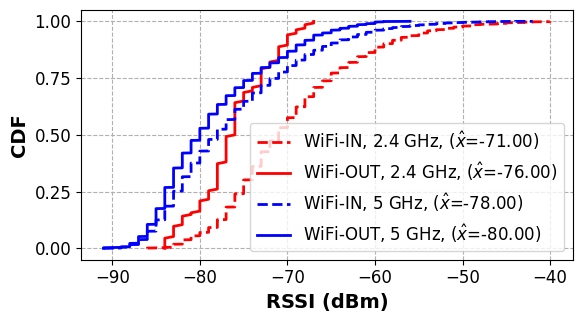

In [21]:
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.rcParams['text.usetex'] = False 

df_temp = df_wifi_in_walmart[df_wifi_in_walmart['primary_freq_mhz']<3000]["rssi_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"WiFi-IN, 2.4 GHz, ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="r")
del df_temp

df_temp = df_wifi_out_walmart[df_wifi_out_walmart['primary_freq_mhz']<3000]["rssi_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"WiFi-OUT, 2.4 GHz, ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='-', color="r")
del df_temp

df_temp = df_wifi_in_walmart[df_wifi_in_walmart['primary_freq_mhz']>=3000]["rssi_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"WiFi-IN, 5 GHz, ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="b")
del df_temp

df_temp = df_wifi_out_walmart[df_wifi_out_walmart['primary_freq_mhz']>=3000]["rssi_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"WiFi-OUT, 5 GHz, ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='-', color="b")
del df_temp

ax.set_xlabel('RSSI (dBm)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.show()

*** ToDo: Check if there are BSSID that have different SSID

In [22]:
# common_bssid = set(df_wifi_in['bssid']).intersection(set(df_wifi_out['bssid']))
# df_wifi_in_common = df_wifi_in[df_wifi_in['bssid'].isin(common_bssid)]
# df_wifi_out_common = df_wifi_out[df_wifi_out['bssid'].isin(common_bssid)]

# bssid_counts_in = df_wifi_in_common['bssid'].value_counts()
# bssid_counts_out = df_wifi_out_common['bssid'].value_counts()

# thresh = 40
# common_bssid_filtered = bssid_counts_in[bssid_counts_in > thresh].index.intersection(
#     bssid_counts_out[bssid_counts_out > thresh].index
# )

# df_wifi_in_common_filt = df_wifi_in_common[df_wifi_in_common['bssid'].isin(common_bssid_filtered)]
# df_wifi_out_common_filt = df_wifi_out_common[df_wifi_out_common['bssid'].isin(common_bssid_filtered)]

# print(df_wifi_in_common_filt[['bssid', 'ssid']].value_counts().sort_index())
# print('\n')
# print(df_wifi_out_common_filt[['bssid', 'ssid']].value_counts().sort_index())

# fig, ax = plt.subplots(figsize=(6, 4))
# plt.rcParams['text.usetex'] = False 

# df_temp = df_wifi_in_common_filt[df_wifi_in_common_filt['bssid']=='00:30:44:4d:74:6e']["rssi_dbm"].dropna().sort_values()
# ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
#     label=rf"bssid_1, 2.4 GHz, ($\hat{{x}}$={df_temp.median():.2f})",
#     markersize=12, linewidth=2, linestyle='--', color="r")
# del df_temp

# df_temp = df_wifi_out_common_filt[df_wifi_out_common_filt['bssid']=='00:30:44:4d:74:6e']["rssi_dbm"].dropna().sort_values()
# ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
#     label=rf"bssid_1, 2.4 GHz, ($\hat{{x}}$={df_temp.median():.2f})",
#     markersize=12, linewidth=2, linestyle='-', color="r")
# del df_temp

# df_temp = df_wifi_in_common_filt[df_wifi_in_common_filt['bssid']=='90:d0:92:a8:72:94']["rssi_dbm"].dropna().sort_values()
# ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
#     label=rf"bssid_2, 2.4 GHz, ($\hat{{x}}$={df_temp.median():.2f})",
#     markersize=12, linewidth=2, linestyle='--', color="b")
# del df_temp

# df_temp = df_wifi_out_common_filt[df_wifi_out_common_filt['bssid']=='90:d0:92:a8:72:94']["rssi_dbm"].dropna().sort_values()
# ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
#     label=rf"bssid_2, 2.4 GHz, ($\hat{{x}}$={df_temp.median():.2f})",
#     markersize=12, linewidth=2, linestyle='-', color="b")
# del df_temp

# ax.set_xlabel('RSSI (dBm)', fontsize=14, fontweight='bold')
# ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
# # ax.set_title('AAA', fontsize=16, fontweight='bold')
# ax.yaxis.set_minor_locator(AutoLocator())
# ax.grid(True, linestyle='--', which='both', axis='both')
# plt.yticks(fontsize=12)
# plt.xticks(fontsize=12)
# plt.legend(fontsize=12, loc='lower right')
# plt.tight_layout()
# plt.show()

# del common_bssid, df_wifi_in_common, df_wifi_out_common, bssid_counts_in, bssid_counts_out, thresh, common_bssid_filtered, df_wifi_in_common_filt, df_wifi_out_common_filt

bssid              ssid         primary_freq_mhz
5c:5b:35:60:0a:f8  Walmartwifi  5180                 74
5c:5b:35:60:2c:58  Walmartwifi  5180                233
5c:5b:35:60:2d:d8  Walmartwifi  5785                 83
d4:20:b0:d6:e5:ac  Walmartwifi  5320                678
d4:20:b0:d6:e5:c5  Walmartwifi  2462                265
d4:20:b0:d6:ec:6e  Walmartwifi  5300                313
                                5765                 98
Name: count, dtype: int64


bssid              ssid         primary_freq_mhz
5c:5b:35:60:0a:f8  Walmartwifi  5180                479
5c:5b:35:60:2c:58  Walmartwifi  5180                 92
5c:5b:35:60:2d:d8  Walmartwifi  5785                205
d4:20:b0:d6:e5:ac  Walmartwifi  5320                 95
d4:20:b0:d6:e5:c5  Walmartwifi  2462                 63
d4:20:b0:d6:ec:6e  Walmartwifi  5300                 53
                                5765                 23
Name: count, dtype: int64


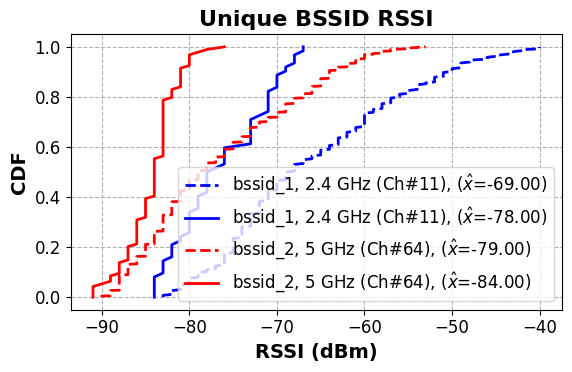

In [23]:
common_bssid = set(df_wifi_in_walmart['bssid']).intersection(set(df_wifi_out_walmart['bssid']))
df_wifi_in_common = df_wifi_in_walmart[df_wifi_in_walmart['bssid'].isin(common_bssid)]
df_wifi_out_common = df_wifi_out_walmart[df_wifi_out_walmart['bssid'].isin(common_bssid)]

bssid_counts_in = df_wifi_in_common['bssid'].value_counts()
bssid_counts_out = df_wifi_out_common['bssid'].value_counts()

thresh = 50
common_bssid_filtered = bssid_counts_in[bssid_counts_in > thresh].index.intersection(
    bssid_counts_out[bssid_counts_out > thresh].index
)

df_wifi_in_common_filt = df_wifi_in_common[df_wifi_in_common['bssid'].isin(common_bssid_filtered)]
df_wifi_out_common_filt = df_wifi_out_common[df_wifi_out_common['bssid'].isin(common_bssid_filtered)]

print(df_wifi_in_common_filt[['bssid', 'ssid', 'primary_freq_mhz']].value_counts().sort_index())
print('\n')
print(df_wifi_out_common_filt[['bssid', 'ssid', 'primary_freq_mhz']].value_counts().sort_index())

fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams['text.usetex'] = False 

df_temp = df_wifi_in_common_filt[df_wifi_in_common_filt['bssid']=='d4:20:b0:d6:e5:c5']["rssi_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"bssid_1, 2.4 GHz (Ch#11), ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="b")
del df_temp

df_temp = df_wifi_out_common_filt[df_wifi_out_common_filt['bssid']=='d4:20:b0:d6:e5:c5']["rssi_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"bssid_1, 2.4 GHz (Ch#11), ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='-', color="b")
del df_temp

df_temp = df_wifi_in_common_filt[df_wifi_in_common_filt['bssid']=='d4:20:b0:d6:e5:ac']["rssi_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"bssid_2, 5 GHz (Ch#64), ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="r")
del df_temp

df_temp = df_wifi_out_common_filt[df_wifi_out_common_filt['bssid']=='d4:20:b0:d6:e5:ac']["rssi_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"bssid_2, 5 GHz (Ch#64), ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='-', color="r")
del df_temp

ax.set_xlabel('RSSI (dBm)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
ax.set_title('Unique BSSID RSSI', fontsize=16, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.show()

plot_geo_scatter_map(df_wifi_in_common_filt[df_wifi_in_common_filt['bssid']=='d4:20:b0:d6:e5:c5'], value_col="rssi_dbm", title="bssid_1 IN", colorbar_title="RSSI (dBm)", unit="dBm")
plot_geo_scatter_map(df_wifi_out_common_filt[df_wifi_out_common_filt['bssid']=='d4:20:b0:d6:e5:c5'], value_col="rssi_dbm", title="bssid_1 OUT", colorbar_title="RSSI (dBm)", unit="dBm")

plot_geo_scatter_map(df_wifi_in_common_filt[df_wifi_in_common_filt['bssid']=='d4:20:b0:d6:e5:ac'], value_col="rssi_dbm", title="bssid_2 IN", colorbar_title="RSSI (dBm)", unit="dBm")
plot_geo_scatter_map(df_wifi_out_common_filt[df_wifi_out_common_filt['bssid']=='d4:20:b0:d6:e5:ac'], value_col="rssi_dbm", title="bssid_2 OUT", colorbar_title="RSSI (dBm)", unit="dBm")

del common_bssid, df_wifi_in_common, df_wifi_out_common, bssid_counts_in, bssid_counts_out, thresh, common_bssid_filtered, df_wifi_in_common_filt, df_wifi_out_common_filt, fig, ax

In [24]:
print(df_wifi_in_walmart[['channel_num', 'center_freq_mhz']].value_counts().sort_index())
print('\n')
print(df_wifi_out_walmart[['channel_num', 'center_freq_mhz']].value_counts().sort_index())

channel_num  center_freq_mhz
1.0          2412                346
6.0          2437                327
11.0         2462                715
36.0         5180                596
40.0         5200               1129
44.0         5220                628
48.0         5240               1019
52.0         5260                240
56.0         5280               1615
60.0         5300                548
64.0         5320               2630
100.0        5500               1766
104.0        5520               1002
108.0        5540               1989
136.0        5680               3276
140.0        5700                242
149.0        5745                776
153.0        5765               1185
157.0        5785                223
161.0        5805                637
165.0        5825               1021
Name: count, dtype: int64


channel_num  center_freq_mhz
1.0          2412                30
6.0          2437                22
11.0         2462                83
36.0         5180            

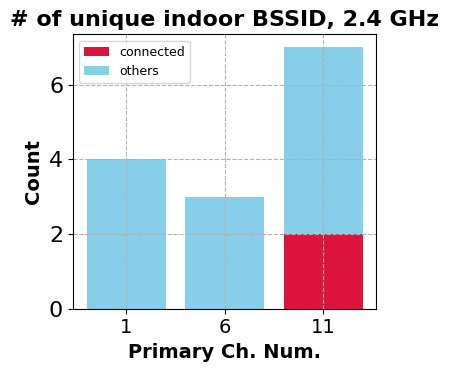

In [25]:
df_focus = df_wifi_in_walmart[df_wifi_in_walmart['center_freq_mhz']<5000]
chlist = sorted(df_focus['channel_num'].astype(int).unique())

data_conn = df_focus[
    df_focus["connected"] == True
][["bssid", "channel_num"]].groupby("channel_num")["bssid"].nunique().reset_index()
for ch in chlist:
    if ch not in data_conn["channel_num"].values:
        data_conn = pd.concat(
            [data_conn, pd.DataFrame({"channel_num": [ch], "bssid": [0]})],
            ignore_index=True
        ).sort_values("channel_num")
data_other = df_focus[
    df_focus["connected"] == False
][["bssid", "channel_num"]].groupby("channel_num")["bssid"].nunique().reset_index()
for ch in chlist:
    if ch not in data_other["channel_num"].values:
        data_other = pd.concat(
            [data_other, pd.DataFrame({"channel_num": [ch], "bssid": [0]})],
            ignore_index=True
        ).sort_values("channel_num")

fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(np.arange(0, data_conn.shape[0]), data_conn["bssid"], color='crimson',
       label='connected')
ax.bar(np.arange(0, data_other.shape[0]), data_other["bssid"], color='skyblue',
       label='others', bottom=data_conn["bssid"])
label_y = .85 * (np.max(data_conn["bssid"]) + np.max(data_other["bssid"]))

ax.set_xlabel('Primary Ch. Num.', fontsize=14, fontweight='bold')
ax.set_ylabel('Count', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.title("# of unique indoor BSSID, 2.4 GHz", fontsize=16, fontweight='bold')
plt.xticks(np.arange(len(chlist)), chlist, fontsize=14)
plt.legend(fontsize=9, loc='best')
plt.tight_layout()
# plt.savefig("plots/cdf-rsrp-outdoor-all.pdf")
plt.show()
plt.close()

del df_focus, chlist, data_conn, data_other, fig, ax, ch, label_y

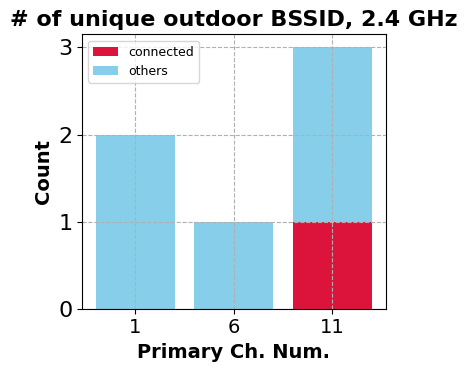

In [26]:
df_focus = df_wifi_out_walmart[df_wifi_out_walmart['center_freq_mhz']<5000]
chlist = sorted(df_focus['channel_num'].astype(int).unique())

data_conn = df_focus[
    df_focus["connected"] == True
][["bssid", "channel_num"]].groupby("channel_num")["bssid"].nunique().reset_index()
for ch in chlist:
    if ch not in data_conn["channel_num"].values:
        data_conn = pd.concat(
            [data_conn, pd.DataFrame({"channel_num": [ch], "bssid": [0]})],
            ignore_index=True
        ).sort_values("channel_num")
data_other = df_focus[
    df_focus["connected"] == False
][["bssid", "channel_num"]].groupby("channel_num")["bssid"].nunique().reset_index()
for ch in chlist:
    if ch not in data_other["channel_num"].values:
        data_other = pd.concat(
            [data_other, pd.DataFrame({"channel_num": [ch], "bssid": [0]})],
            ignore_index=True
        ).sort_values("channel_num")

fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(np.arange(0, data_conn.shape[0]), data_conn["bssid"], color='crimson',
       label='connected')
ax.bar(np.arange(0, data_other.shape[0]), data_other["bssid"], color='skyblue',
       label='others', bottom=data_conn["bssid"])
label_y = .85 * (np.max(data_conn["bssid"]) + np.max(data_other["bssid"]))

ax.set_xlabel('Primary Ch. Num.', fontsize=14, fontweight='bold')
ax.set_ylabel('Count', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.title("# of unique outdoor BSSID, 2.4 GHz", fontsize=16, fontweight='bold')
plt.xticks(np.arange(len(chlist)), chlist, fontsize=14)
plt.legend(fontsize=9, loc='best')
plt.tight_layout()
# plt.savefig("plots/cdf-rsrp-outdoor-all.pdf")
plt.show()
plt.close()

del df_focus, chlist, data_conn, data_other, fig, ax, ch, label_y

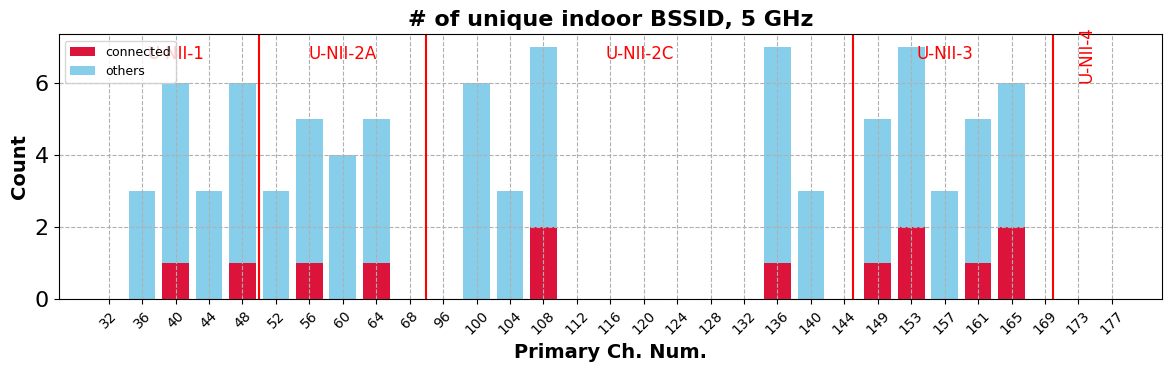

In [27]:
df_focus = df_wifi_in_walmart[df_wifi_in_walmart['center_freq_mhz']>5000]

chlist = [32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 149, 153, 157, 161, 165, 169, 173, 177]

data_conn = df_focus[
    df_focus["connected"] == True
][["bssid", "primary_ch_num"]].groupby("primary_ch_num")["bssid"].nunique().reset_index()
for ch in chlist:
    if ch not in data_conn["primary_ch_num"].values:
        data_conn = pd.concat(
            [data_conn, pd.DataFrame({"primary_ch_num": [ch], "bssid": [0]})],
            ignore_index=True
        ).sort_values("primary_ch_num")

data_other = df_focus[
    df_focus["connected"] == False
][["bssid", "primary_ch_num"]].groupby("primary_ch_num")["bssid"].nunique().reset_index()
for ch in chlist:
    if ch not in data_other["primary_ch_num"].values:
        data_other = pd.concat(
            [data_other, pd.DataFrame({"primary_ch_num": [ch], "bssid": [0]})],
            ignore_index=True
        ).sort_values("primary_ch_num")

fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(np.arange(0, data_conn.shape[0]), data_conn["bssid"], color='crimson',
       label='connected')
ax.bar(np.arange(0, data_other.shape[0]), data_other["bssid"], color='skyblue',
       label='others', bottom=data_conn["bssid"])

label_y = .85 * (np.max(data_conn["bssid"]) + np.max(data_other["bssid"]))
ax.text(2, label_y, 'U-NII-1', fontsize=12, color='r', ha='center', va='center')
ax.axvline(x=4.5, color='r', linestyle='-')
ax.text(7, label_y, 'U-NII-2A', fontsize=12, color='r', ha='center', va='center')
ax.axvline(x=9.5, color='r', linestyle='-')
ax.text(12.75/2+9.5, label_y, 'U-NII-2C', fontsize=12, color='r', ha='center', va='center')
ax.axvline(x=22.5-0.25, color='r', linestyle='-')
ax.text(5.5/2+22.5-0.25, label_y, 'U-NII-3', fontsize=12, color='r', ha='center', va='center')
ax.axvline(x=28.5-0.25, color='r', linestyle='-')
ax.text(28.5-0.25+1, label_y, 'U-NII-4', fontsize=12, color='r', ha='center', va='center', rotation=90)

ax.set_xlabel('Primary Ch. Num.', fontsize=14, fontweight='bold')
ax.set_ylabel('Count', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.title("# of unique indoor BSSID, 5 GHz", fontsize=16, fontweight='bold')
plt.xlim(-1.5, 31.5)
plt.xticks(np.arange(len(chlist)), chlist, fontsize=10, rotation=45)
plt.legend(fontsize=9, loc='best')
plt.tight_layout()
# plt.savefig("plots/cdf-rsrp-outdoor-all.pdf")
plt.show()
plt.close()

del df_focus, chlist, data_conn, data_other, ch, label_y, fig, ax

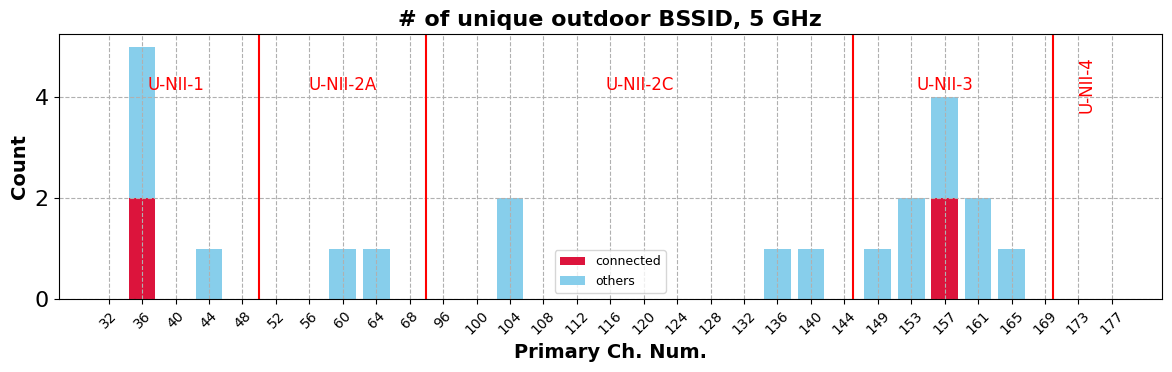

In [28]:
df_focus = df_wifi_out_walmart[df_wifi_out_walmart['center_freq_mhz']>5000]

chlist = [32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 149, 153, 157, 161, 165, 169, 173, 177]

data_conn = df_focus[
    df_focus["connected"] == True
][["bssid", "primary_ch_num"]].groupby("primary_ch_num")["bssid"].nunique().reset_index()
for ch in chlist:
    if ch not in data_conn["primary_ch_num"].values:
        data_conn = pd.concat(
            [data_conn, pd.DataFrame({"primary_ch_num": [ch], "bssid": [0]})],
            ignore_index=True
        ).sort_values("primary_ch_num")

data_other = df_focus[
    df_focus["connected"] == False
][["bssid", "primary_ch_num"]].groupby("primary_ch_num")["bssid"].nunique().reset_index()
for ch in chlist:
    if ch not in data_other["primary_ch_num"].values:
        data_other = pd.concat(
            [data_other, pd.DataFrame({"primary_ch_num": [ch], "bssid": [0]})],
            ignore_index=True
        ).sort_values("primary_ch_num")

fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(np.arange(0, data_conn.shape[0]), data_conn["bssid"], color='crimson',
       label='connected')
ax.bar(np.arange(0, data_other.shape[0]), data_other["bssid"], color='skyblue',
       label='others', bottom=data_conn["bssid"])

label_y = .85 * (np.max(data_conn["bssid"]) + np.max(data_other["bssid"]))
ax.text(2, label_y, 'U-NII-1', fontsize=12, color='r', ha='center', va='center')
ax.axvline(x=4.5, color='r', linestyle='-')
ax.text(7, label_y, 'U-NII-2A', fontsize=12, color='r', ha='center', va='center')
ax.axvline(x=9.5, color='r', linestyle='-')
ax.text(12.75/2+9.5, label_y, 'U-NII-2C', fontsize=12, color='r', ha='center', va='center')
ax.axvline(x=22.5-0.25, color='r', linestyle='-')
ax.text(5.5/2+22.5-0.25, label_y, 'U-NII-3', fontsize=12, color='r', ha='center', va='center')
ax.axvline(x=28.5-0.25, color='r', linestyle='-')
ax.text(28.5-0.25+1, label_y, 'U-NII-4', fontsize=12, color='r', ha='center', va='center', rotation=90)

ax.set_xlabel('Primary Ch. Num.', fontsize=14, fontweight='bold')
ax.set_ylabel('Count', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.title("# of unique outdoor BSSID, 5 GHz", fontsize=16, fontweight='bold')
plt.xlim(-1.5, 31.5)
plt.xticks(np.arange(len(chlist)), chlist, fontsize=10, rotation=45)
plt.legend(fontsize=9, loc='best')
plt.tight_layout()
# plt.savefig("plots/cdf-rsrp-outdoor-all.pdf")
plt.show()
plt.close()

del df_focus, chlist, data_conn, data_other, ch, label_y, fig, ax

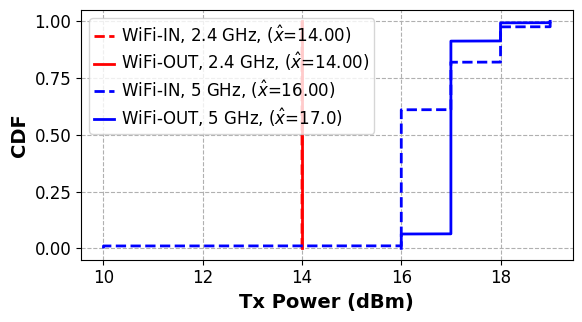

In [29]:
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.rcParams['text.usetex'] = False 

df_temp = df_wifi_in_walmart[df_wifi_in_walmart['primary_freq_mhz']<3000]["tx_power_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"WiFi-IN, 2.4 GHz, ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="r")
del df_temp

df_temp = df_wifi_out_walmart[df_wifi_out_walmart['primary_freq_mhz']<3000]["tx_power_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"WiFi-OUT, 2.4 GHz, ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='-', color="r")
del df_temp

df_temp = df_wifi_in_walmart[df_wifi_in_walmart['primary_freq_mhz']>=3000]["tx_power_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"WiFi-IN, 5 GHz, ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="b")
del df_temp

df_temp = df_wifi_out_walmart[df_wifi_out_walmart['primary_freq_mhz']>=3000]["tx_power_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"WiFi-OUT, 5 GHz, ($\hat{{x}}$={df_temp.median():.1f})",
    markersize=12, linewidth=2, linestyle='-', color="b")
del df_temp

ax.set_xlabel('Tx Power (dBm)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left', handlelength=1.2, handletextpad=0.4, borderpad=0.3, labelspacing=0.3)
plt.tight_layout()
plt.show()

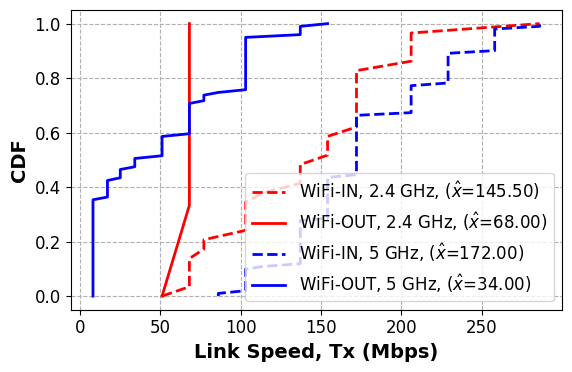

In [30]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams['text.usetex'] = False 

df_wifi_in_conn_2ghz = df_wifi_in_conn[df_wifi_in_conn['primary_freq_mhz']<3000]["tx_link_speed"].dropna().sort_values()
ax.plot(df_wifi_in_conn_2ghz,np.linspace(0, 1, df_wifi_in_conn_2ghz.shape[0]),
    label=rf"WiFi-IN, 2.4 GHz, ($\hat{{x}}$={df_wifi_in_conn_2ghz.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="r")

df_wifi_out_conn_2ghz = df_wifi_out_conn[df_wifi_out_conn['primary_freq_mhz']<3000]["tx_link_speed"].dropna().sort_values()
ax.plot(df_wifi_out_conn_2ghz,np.linspace(0, 1, df_wifi_out_conn_2ghz.shape[0]),
    label=rf"WiFi-OUT, 2.4 GHz, ($\hat{{x}}$={df_wifi_out_conn_2ghz.median():.2f})",
    markersize=12, linewidth=2, linestyle='-', color="r")

df_wifi_in_conn_5ghz = df_wifi_in_conn[df_wifi_in_conn['primary_freq_mhz']>=3000]["tx_link_speed"].dropna().sort_values()
ax.plot(df_wifi_in_conn_5ghz,np.linspace(0, 1, df_wifi_in_conn_5ghz.shape[0]),
    label=rf"WiFi-IN, 5 GHz, ($\hat{{x}}$={df_wifi_in_conn_5ghz.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="b")
df_wifi_out_conn_5ghz = df_wifi_out_conn[df_wifi_out_conn['primary_freq_mhz']>=3000]["tx_link_speed"].dropna().sort_values()
ax.plot(df_wifi_out_conn_5ghz,np.linspace(0, 1, df_wifi_out_conn_5ghz.shape[0]),
    label=rf"WiFi-OUT, 5 GHz, ($\hat{{x}}$={df_wifi_out_conn_5ghz.median():.2f})",
    markersize=12, linewidth=2, linestyle='-', color="b")

ax.set_xlabel('Link Speed, Tx (Mbps)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.show()

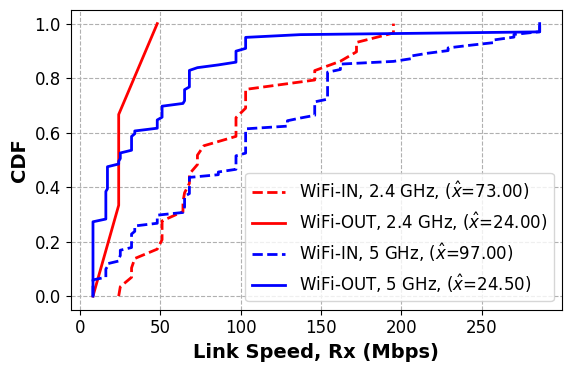

In [31]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams['text.usetex'] = False 

df_wifi_in_conn_2ghz = df_wifi_in_conn[df_wifi_in_conn['primary_freq_mhz']<3000]["rx_link_speed"].dropna().sort_values()
ax.plot(df_wifi_in_conn_2ghz,np.linspace(0, 1, df_wifi_in_conn_2ghz.shape[0]),
    label=rf"WiFi-IN, 2.4 GHz, ($\hat{{x}}$={df_wifi_in_conn_2ghz.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="r")

df_wifi_out_conn_2ghz = df_wifi_out_conn[df_wifi_out_conn['primary_freq_mhz']<3000]["rx_link_speed"].dropna().sort_values()
ax.plot(df_wifi_out_conn_2ghz,np.linspace(0, 1, df_wifi_out_conn_2ghz.shape[0]),
    label=rf"WiFi-OUT, 2.4 GHz, ($\hat{{x}}$={df_wifi_out_conn_2ghz.median():.2f})",
    markersize=12, linewidth=2, linestyle='-', color="r")

df_wifi_in_conn_5ghz = df_wifi_in_conn[df_wifi_in_conn['primary_freq_mhz']>=3000]["rx_link_speed"].dropna().sort_values()
ax.plot(df_wifi_in_conn_5ghz,np.linspace(0, 1, df_wifi_in_conn_5ghz.shape[0]),
    label=rf"WiFi-IN, 5 GHz, ($\hat{{x}}$={df_wifi_in_conn_5ghz.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="b")
df_wifi_out_conn_5ghz = df_wifi_out_conn[df_wifi_out_conn['primary_freq_mhz']>=3000]["rx_link_speed"].dropna().sort_values()
ax.plot(df_wifi_out_conn_5ghz,np.linspace(0, 1, df_wifi_out_conn_5ghz.shape[0]),
    label=rf"WiFi-OUT, 5 GHz, ($\hat{{x}}$={df_wifi_out_conn_5ghz.median():.2f})",
    markersize=12, linewidth=2, linestyle='-', color="b")

ax.set_xlabel('Link Speed, Rx (Mbps)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.show()

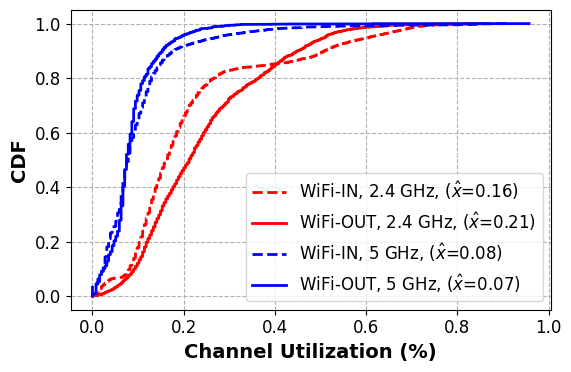

In [33]:
### Channel Utilization of ALL SSIDs

fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams['text.usetex'] = False 

df_temp = df_wifi_in[df_wifi_in['primary_freq_mhz']<3000]["ch_util"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"WiFi-IN, 2.4 GHz, ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="r")
del df_temp

df_temp = df_wifi_out[df_wifi_out['primary_freq_mhz']<3000]["ch_util"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"WiFi-OUT, 2.4 GHz, ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='-', color="r")
del df_temp

df_temp = df_wifi_in[df_wifi_in['primary_freq_mhz']>=3000]["ch_util"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"WiFi-IN, 5 GHz, ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="b")
del df_temp

df_temp = df_wifi_out[df_wifi_out['primary_freq_mhz']>=3000]["ch_util"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"WiFi-OUT, 5 GHz, ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='-', color="b")
del df_temp

ax.set_xlabel('Channel Utilization (%)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.show()